In [2]:
import glob,os,sys,sncosmo,pyParz
import sncosmo
import sntd
from sntd import simulation, fitting,io,models,util
from sntd.plotting import _COLORLIST5
import numpy as np
from scipy import stats
from copy import copy,deepcopy
from astropy.table import vstack
from astropy.io import ascii
from matplotlib import pyplot as plt
from astropy.table import Table

In [9]:
times=[-3.932323367086956978e+01,-3.832323367086956978e+01,
       -2.832323367086956978e+01,-1.832323367086956978e+01,
       -8.323233670869569778e+00,1.676766329130430222e+00,
       1.167676632913043022e+01,2.167676632913043022e+01,
       3.167676632913043022e+01,4.167676632913043022e+01,
       5.167676632913043022e+01,6.167676632913043022e+01,
       7.167676632913043022e+01,8.167676632913043022e+01,
       9.167676632913043022e+01,1.016767663291304302e+02,
       1.116767663291304302e+02,1.216767663291304302e+02,
       1.316767663291304302e+02,1.416767663291304302e+02]

times=[1.990268257528885343e+01,2.090268257528885343e+01,3.090268257528885343e+01,4.090268257528884988e+01,5.090268257528884988e+01,6.090268257528884988e+01,7.09\
0268257528884988e+01,8.090268257528884988e+01,9.090268257528884988e+01,1.009026825752888499e+02,1.109026825752888499e+02,1.209026825752888499e+02,1.3090268257528\
88499e+02,1.409026825752888499e+02]

Simulating...0
       flux       
------------------
10.972890815659248
11.406471506427044
 10.28770110953352
 8.142303436741017
 7.940955713936504
 8.135453389565212
 7.381457970094133
 7.669106526473787
 6.566645935858592
 5.188486105713045
 6.817060735827245
 5.385779517051401
 4.850507180081438
4.8657720464238094
       flux       
------------------
1.1872341081696307
 2.271239003444574
 4.353058407791319
 7.111835013825726
 10.30429682229464
  9.57233324367821
  9.88869782197169
   5.8206492885518
 7.117835630365775
 6.596622087466558
 4.931442198020303
 6.511751769488279
 4.069290386959951
 4.087914395697033
Simulating...1
       flux       
------------------
 7.316979681833851
6.1745008902549765
 3.670167707016663
 5.851054656636879
 5.522248908630868
 3.689024263845962
4.2823798747857635
3.9644099765608614
 4.336633369210617
3.3156621590863598
3.6355989942940283
 5.002524767604489
2.7098539419587655
 3.479565304133125
        flux       
-------------------
 1.131203808468127

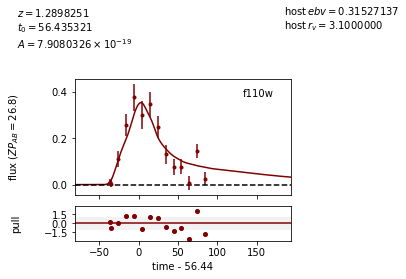

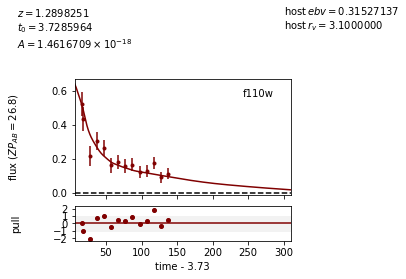

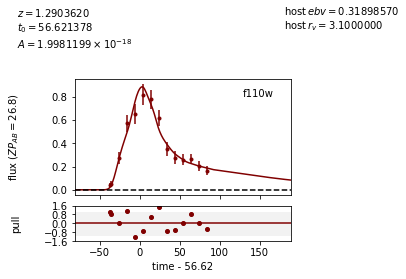

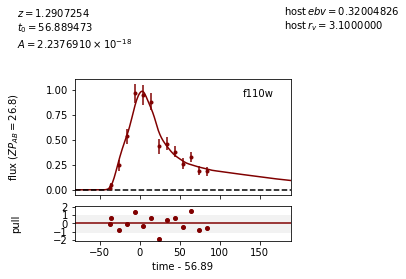

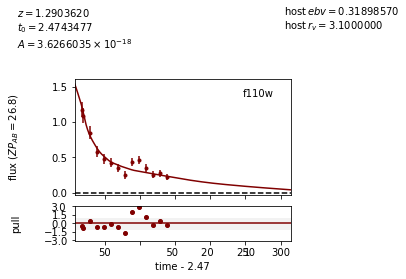

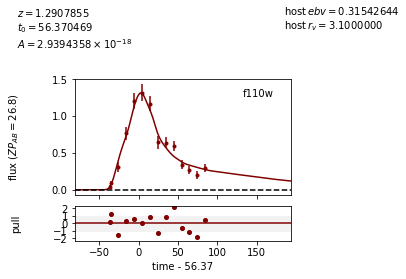

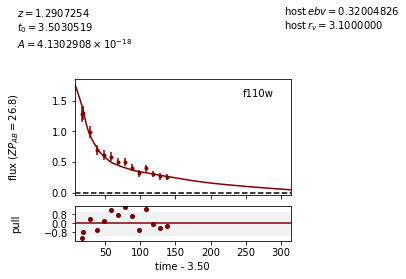

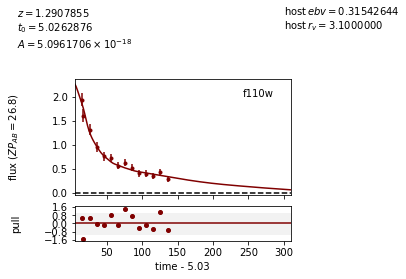

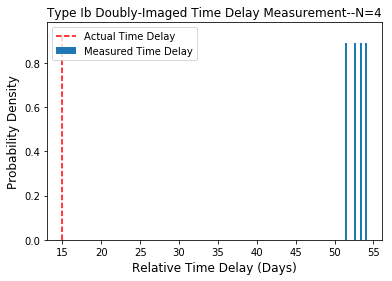

In [21]:
#TODO: Make this parallelization a function inside SNTD
reload(simulation)
reload(fitting)
nsim = 4
zp=26.8
zpsys='AB'
dt_fit_list = [] 
murel_fit_list = [] 
inds={'time':0,'flux':1,'fluxerr':2,'object':3}
default={'zp':zp,'zpsys':'AB','band':'F110W'}

def _td_par(args):  
    lcs=io.curveDict()
    for t in args:
        temp=Table()
        for name in ['time','band','flux','fluxerr','zp','zpsys']:
            if name in ['time','flux','fluxerr']:
                temp[name]=t[inds[name]]
                
            else:
                
                temp[name]=default[name]
            
        curve_i=io.curve(zp=zp,zpsys=zpsys)
        curve_i.table=temp
        
        curve_i.object=t[inds['object']]
        
        curve_i.bands=['F110W']
        lcs.add_curve(curve_i)

    # Part 2: fit each light curve separately to determine lensing parameters
    print("Fitting strongly lensed SN %i"%args[0][-1])
    lcs_tdfit=fitting.fit_data(lcs, snType='Ib', models=['snana-2004gv'],
                               dust='CCM89Dust',effect_frames=['rest'],
                                effect_names=['host'],
                               params=['z','amplitude','t0','hostebv'],
                               bounds={'hostebv':(0,.5),'z':(1.26,1.32),'t0':(-25,10)},
                               combined_or_separate='separate',showPlots=True)
    


    return(np.abs(lcs_tdfit.time_delays['S2']))

simmed=[]
#Currently in order to make unique SNe they need to be created in serial 
#then fit in parallel, I'll look into this
for isim in range(nsim):
    print("Simulating...%i"%isim)
    modname = 'snana-2004gv'
    snType = 'Ib'
    bandlist = ['F110W']
    lcs = simulation.createMultiplyImagedSN(
        modname, snType, 1.28, bands=bandlist,
        zp=zp, skynoiseRange=[0.001,0.005],gain=100.,cadence=1., epochs=10.,
        timeArr=times, time_delays=[0., 56.],
        magnifications=[2.6,1.3], objectName='Test'+snType, 
        telescopename='HST',z_lens=0.5, 
        microlensing_type=None,minsnr=5.0)
    simmed.append([[np.array(lcs.images[k].table['time']),
            np.array(lcs.images[k].table['flux']),
            np.array(lcs.images[k].table['fluxerr']),k,isim] for k in lcs.images.keys()])

print("")
dt_fit_list=pyParz.foreach(simmed,_td_par,None)

#plot the resulting histogram
fig=plt.figure()
ax=fig.gca() 
ax.hist(dt_fit_list,rwidth=1,normed=True,label='Measured Time Delay')

ax.plot([15,15],ax.get_ylim(),'r--',label='Actual Time Delay') 
ax.legend(loc='upper left',fontsize=10) 
ax.set_title('Type Ib Doubly-Imaged Time Delay Measurement--N='+str(nsim),size=12) 
ax.set_ylabel('Probability Density',size=12) 
ax.set_xlabel('Relative Time Delay (Days)',size=12) 
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.show()
plt.close()
#np.savetxt('tds.dat',dt_fit_list) #uncomment to output the histogram data


Simulating...0
       flux       
------------------
23.959480972069514
23.138113300659445
19.502015865562363
17.305318375218356
15.876242513987377
11.270082063445525
14.371970440787475
11.028517111825252
10.744728955772596
 8.837635716686567
 9.076853246487401
       flux       
------------------
 4.271230323809669
6.5206897032400315
13.283837405113477
14.460233359493962
 17.32407096017692
17.044360766749907
17.194478734149296
15.179504390279543
12.951938056298463
12.945423013766234
  9.01796547123344
  8.49008673627487
 9.168983269182553
  8.48973058106287
Simulating...1
       flux       
------------------
 26.64851300016702
27.919750631887773
25.802419525347613
23.935962844504566
18.586198570194515
 19.74764083960958
15.540798101238982
13.096237408804521
 12.60020140132951
12.281205195041354
10.079238589354762
       flux       
------------------
7.5345967958886195
 9.702578651096795
 17.41788543524656
 20.33790901549574
 21.81347163139569
21.944147308621197
 21.35476845792442
2

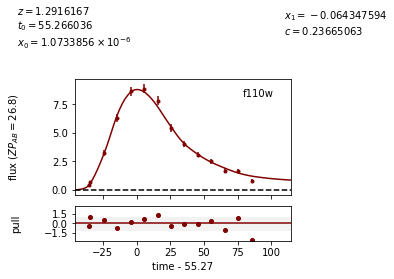

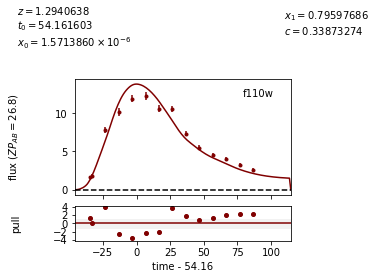

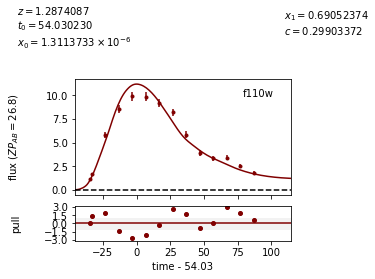

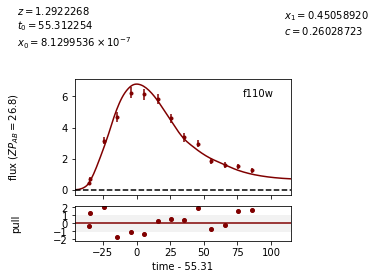

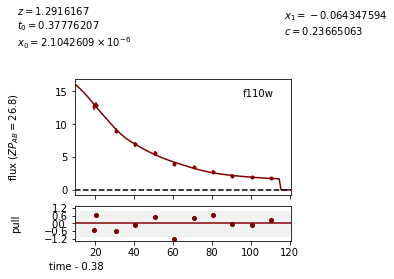

Fitting strongly lensed SN 4


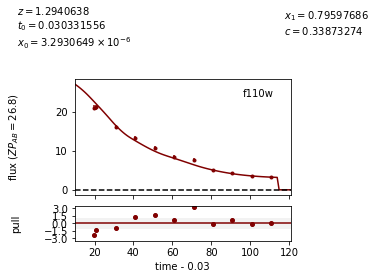

Fitting strongly lensed SN 5


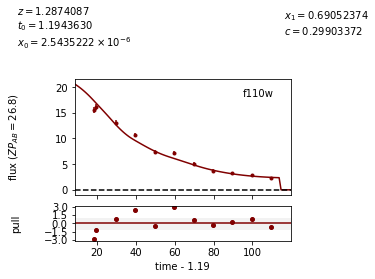

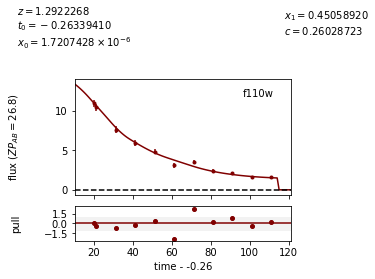

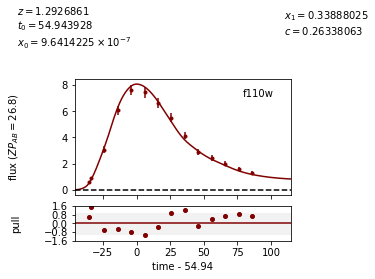

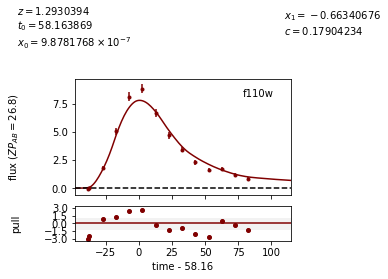

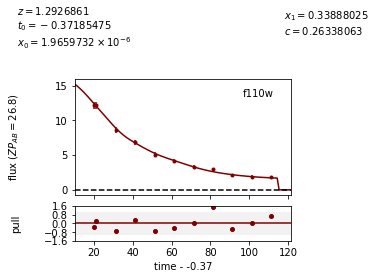

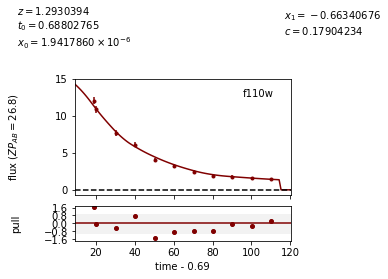

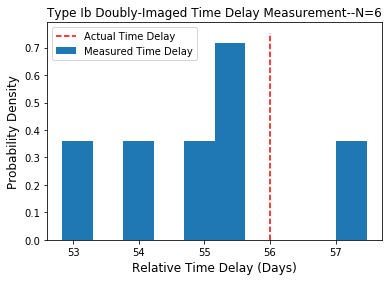

In [27]:
#Running specifically for Ia
#TODO: Make this parallelization a function inside SNTD
reload(fitting)
reload(simulation)
nsim = 6
zp=26.8
zpsys='AB'
dt_fit_list = [] 
murel_fit_list = [] 
inds={'time':0,'flux':1,'fluxerr':2,'object':3}
default={'zp':zp,'zpsys':'AB','band':'F110W'}

def _td_par(args):  
    lcs=io.curveDict()
    for t in args:
        temp=Table()
        for name in ['time','band','flux','fluxerr','zp','zpsys']:
            if name in ['time','flux','fluxerr']:
                temp[name]=t[inds[name]]
                
            else:
                
                temp[name]=default[name]
            
        curve_i=io.curve(zp=zp,zpsys=zpsys)
        curve_i.table=temp
        
        curve_i.object=t[inds['object']]
        
        curve_i.bands=['F110W']
        lcs.add_curve(curve_i)

    # Part 2: fit each light curve separately to determine lensing parameters
    print("Fitting strongly lensed SN %i"%args[0][-1])
    lcs_tdfit=fitting.fit_data(lcs, snType='Ia', models=[salt2],
                               dust='CCM89Dust',
                               params=['z', 't0', 'x0', 'x1', 'c'],
                               bounds={'c':(0,.5),'z':(1.26,1.32),'t0':(-5,5)},
                               t0_guess={'S1':0,'S2':56},
                               combined_or_separate='separate',showPlots=True)
    


    return(np.abs(lcs_tdfit.time_delays['S2']))

simmed=[]
#Currently in order to make unique SNe they need to be created in serial 
#then fit in parallel, I'll look into this
#You need to use this version of salt2 if looking at high-z, extends to 
#25000A (Pierel 2018)
salt2=sncosmo.SALT2Source(modeldir='salt2-extended')
for isim in range(nsim):
    print("Simulating...%i"%isim)
    modname = salt2
    snType = 'Ia'
    bandlist = ['F110W']
    lcs = simulation.createMultiplyImagedSN(
        modname, snType, 1.28, bands=bandlist,
        zp=zp, skynoiseRange=[0.001,0.005],gain=50.,timeArr=times,
        time_delays=[0., 56.],
        magnifications=[2.6,1.3], objectName='Test'+snType, 
        telescopename='HST',z_lens=0.51, 
        microlensing_type=None,
        microlensing_params=[4,2,50],minsnr=5.0)
    simmed.append([[np.array(lcs.images[k].table['time']),
            np.array(lcs.images[k].table['flux']),
            np.array(lcs.images[k].table['fluxerr']),k,isim] for k in lcs.images.keys()])

print("")
dt_fit_list=pyParz.foreach(simmed,_td_par,None)

#plot the resulting histogram
fig=plt.figure()
ax=fig.gca() 
ax.hist(dt_fit_list,rwidth=1,normed=True,label='Measured Time Delay')

ax.plot([56,56],ax.get_ylim(),'r--',label='Actual Time Delay') 
ax.legend(loc='upper left',fontsize=10) 
ax.set_title('Type Ib Doubly-Imaged Time Delay Measurement--N='+str(nsim),size=12) 
ax.set_ylabel('Probability Density',size=12) 
ax.set_xlabel('Relative Time Delay (Days)',size=12) 
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.show()
plt.close()
#np.savetxt('tds.dat',dt_fit_list) #uncomment to output the histogram data
